In [50]:
import shap
import torch
import random
import numpy as np
import matplotlib.pyplot as pl
import torchvision.models as models

In [51]:
from PIL import Image
from pathlib import Path
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

In [52]:
from Models.CNN_model import CNN
from Models.VGG19_model import VGG19

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [54]:
cnn = CNN()
cnn.load_state_dict(torch.load('../assets/cnn_model.pth', map_location = device))

original_vgg19_model = models.vgg19(weights = 'VGG19_Weights.DEFAULT')
vgg = VGG19(original_vgg19_model)
vgg.load_state_dict(torch.load('../assets/vgg19_transfer.pth', map_location = device))

<All keys matched successfully>

In [55]:
image_path = list(Path('../../../Thesis/assets/Dataset/Testing/').glob('*/*.jpg'))
test_data_path  = Path('../../../Thesis/assets/Dataset/Testing')

In [56]:
def choose_random_image(image_path: Path):
    image_path = random.choice(image_path)
    image_class = image_path.parent.stem

    image = Image.open(image_path)
    image = image.convert('RGB')
    image = image.resize((224, 224))

    pl.rcParams.update({'font.size': 13})
    pl.figure(figsize = (6, 6))
    pl.imshow(image)
    pl.title(f'{image_class}')
    pl.axis('off')
    pl.show()

    return image, image_class

In [57]:
image_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
])

test_data   = ImageFolder(test_data_path, transform = image_transform)
test_loader = DataLoader(test_data, batch_size = 200, shuffle = False)

In [122]:
def prepare_image(path):
  image_to_explain = Image.open(path)
  image_to_explain = image_to_explain.convert('RGB')
  image_to_explain = image_transform(image_to_explain)
  image_to_explain = image_to_explain.unsqueeze(0)
  image_to_explain = image_to_explain.to(device)

  return image_to_explain

In [123]:
classes: dict[int, str] = { 0 : 'glioma', 
                            1 : 'meningioma', 
                            2 : 'notumor', 
                            3 : 'pituitary' }

In [124]:
batch = next(iter(test_loader))
background , _ = batch
background = background[:10]

In [125]:
def explain_with_shap(model, image_path):
  image = prepare_image(image_path)
  explainer = shap.DeepExplainer(model, background)
  shap_values = explainer.shap_values(image)
  shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
  test_numpy = np.swapaxes(np.swapaxes(image.numpy(), 1, -1), 1, 2)
  labels = ['glejak', 'guz opon mózgowych', 'brak nowotworu', 'guz przysadki']
  shap.image_plot(shap_numpy, test_numpy, labels) 

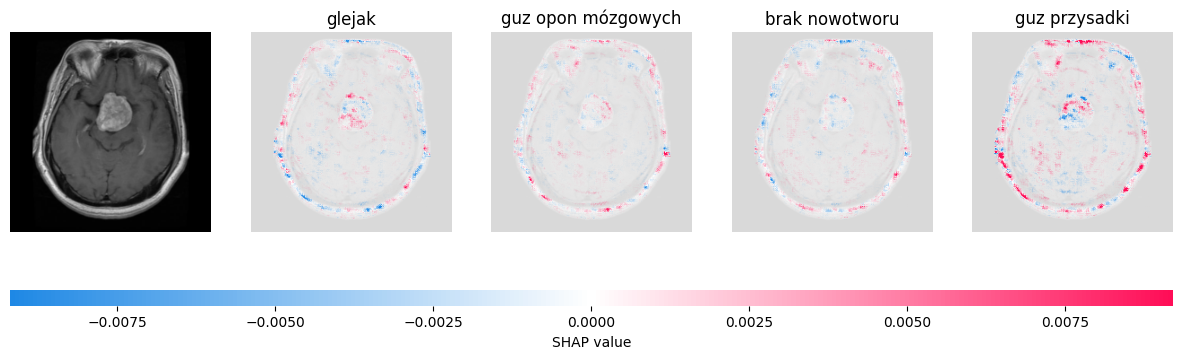

In [126]:
explain_with_shap(cnn, '../assets/test_pituitary.jpg')